# 3.1. Ejercicio

* En este ejercicio vamos a implementar un autoencoder para detectar anomalías o fallos en tejidos.

* Para esto utilizaremos un dataset con imágenes de tejidos en las que se ha etiquetado la posición de los fallos mediante una imagen binaria:
 * Color negro: parte del tejido correcta.
 * Color blanco: fallo.

* Sigue los pasos indicados y completa las líneas marcadas con "**TODO**".

## Descargar datos

* En primer lugar descargamos el dataset y lo descomprimimos.

In [1]:
!wget -q http://www.dlsi.ua.es/~jgallego/deepraltamira/datos/dataset.zip

!unzip -q dataset.zip

<br>

* A continuación cargamos las imágenes del dataset en memoria.

* Además dividimos el dataset en particiones para el entrenamiento y para la evaluación.

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf

tf.random.set_seed(2)  # Fijamos la semilla de TF
np.random.seed(2)  # Fijamos la semilla


#------------------------------------------------------------------------------
def load_dataset():
  X = []
  Y = []
  for fname_x in os.listdir('images'):
    fname_y = fname_x.replace('.png', '_mask.png')
    img_x = cv2.imread(os.path.join('images', fname_x), cv2.IMREAD_COLOR)
    img_y = cv2.imread(os.path.join('gt', fname_y), cv2.IMREAD_GRAYSCALE)
    X.append( cv2.cvtColor(img_x, cv2.COLOR_BGR2RGB) )
    Y.append(img_y)
  X = np.array(X)
  Y = np.array(Y)
  return train_test_split(X, Y, test_size=0.08, random_state=42)


x_train, x_test, y_train, y_test = load_dataset()


# TODO - Muestra la forma (dimensiones) de los datos de entrenamiento y de evaluación
print('Train_images shape:', x_train.shape)
print('Test_images shape:', x_test.shape)




Train_images shape: (114, 128, 128, 3)
Test_images shape: (10, 128, 128, 3)


## Mostrar imágenes de ejemplo

* Mostramos algunas imágenes para analizar el tipo de datos que vamos a utilizar.

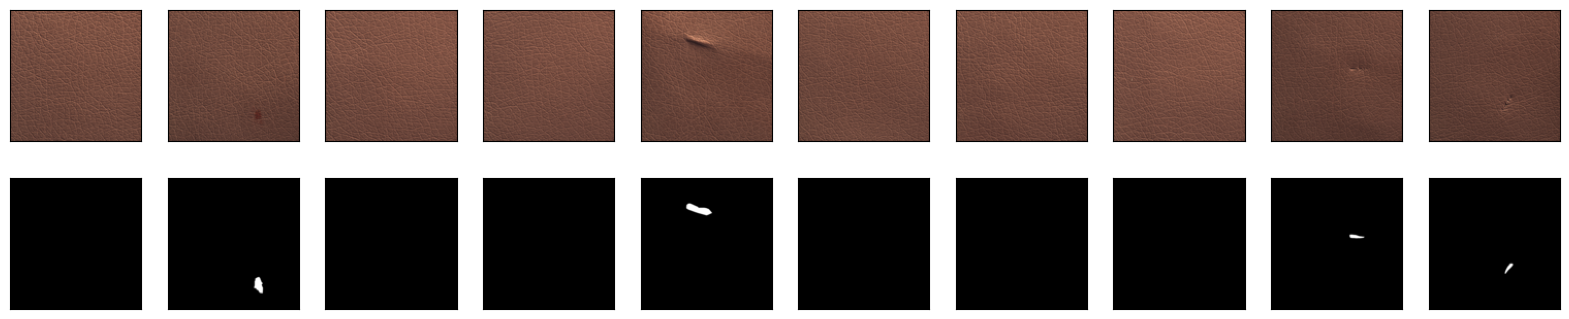

In [3]:

#----------------------------------------------------
def show_images(images, labels):
  n = 10  # Número de imágenes a mostrar
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Mostrar la imagen de entrada
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(images[i])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Mostrar las etiquetas
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(labels[i].reshape(128, 128))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()


# TODO - Llama a la función "show_images" con los parámetros (x_train, y_train)
show_images(x_train, y_train)




## Preparar los datos para el entrenamiento

* Preparamos los datos para el entrenamiento:

 * Añadimos el canal a las imágenes en escala de gris.

 * Transformamos a decimal los datos.

 * Normalizamos entre 0 y 1.


In [5]:
def prepare_data(x, y):
  y =  y.reshape(y.shape[0], y.shape[1], y.shape[2], 1) # TODO - Redimensiona los datos para añadir el canal final

  x =  x.astype(np.float32) # TODO - Transforma la variable "x" a formato float32
  y =  y.astype(np.float32) # TODO - Transforma la variable "y" a formato float32

  x  /= 255   # TODO: Normaliza la variable "x" en el rango 0 y 1
  y  /= 255   # TODO: Normaliza la variable "y" en el rango 0 y 1
  return x, y


x_train, y_train =  prepare_data(x_train, y_train) # TODO: Llama a la función para preparar los datos de entrenamiento
x_test, y_test =    prepare_data(x_test, y_test) # TODO: Llama a la función para preparar los datos de evaluación


# TODO - Muestra la forma (dimensiones) de los datos de entrenamiento y de evaluación
print(x_train.shape)
print(x_test.shape)


(114, 128, 128, 3)
(10, 128, 128, 3)


## Definir el autoencoder

* A continuación definimos el Autoencoder que vamos a utilizar.

* Para aprender estos datos definiremos un Autoencoder Convolucional con:

 * La capa de entrada tendrá una dimensión de 128 x 128 x 3.

 * 3 capas para el encoder con kernels de 3x3 y 32, 16 y 8 filtros en cada capa.

 * 3 capas para el decoder con kernels de 3x3 y 8, 16 y 32 filtros en cada capa.

 * La capa de salida será una capa convolucional con un solo filtro y un kernel de 3x3.

* Entrenaremos esta arquitectura durante 200 épocas con un tamaño de batch de 64.

In [6]:
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.models import Model


# Entrada
input_img =  Input(shape=(128,128,3))  # TODO - Define la entrada con dimensiones 128 x 128 x 3 usando la clase Input


# Encoder...
x = Conv2D( 32, (3, 3), activation='relu', padding='same')(input_img)   # TODO - Establece el número de filtros a 32
x = Dropout(0.1)(x)  # TODO: Añade un Dropout de 0.1
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D( 16, (3, 3), activation='relu', padding='same')(x)          # TODO - Establece el número de filtros a 16
x = Dropout(0.1)(x)   # TODO: Añade un Dropout de 0.1
x = MaxPooling2D((2, 2), padding='same')(x)   # TODO: Añade una capa MaxPooling2D de 2x2 con padding tipo 'same'

x = Conv2D( 8, (3, 3), activation='relu', padding='same')(x)         # TODO - Establece el número de filtros a 8
x = Dropout(0.1)(x)   # TODO: Añade un Dropout de 0.1

encoded =  MaxPooling2D((2, 2), padding='same')(x) # TODO: Añade una capa MaxPooling2D de 2x2 con padding tipo 'same'


# Decoder...
x = Conv2D( 8, (3, 3), activation='relu', padding='same')(encoded)   # TODO - Añade el número de filtros
x = Dropout(0.1)(x)   # TODO: Añade un Dropout de 0.1
x = UpSampling2D((2,2))(x)   # TODO: Añade una capa UpSampling2D de 2x2

x = Conv2D( 16, (3, 3), activation='relu', padding='same')(x)     # TODO - Añade el número de filtros
x = Dropout(0.1)(x)   # TODO: Añade un Dropout de 0.1
x = UpSampling2D((2,2))(x)   # TODO: Añade una capa UpSampling2D de 2x2

x = Conv2D( 32, (3, 3), activation='relu', padding='same')(x)    # TODO - Añade el número de filtros
x = Dropout(0.1)(x)   # TODO: Añade un Dropout de 0.1
x = UpSampling2D((2,2))(x)   # TODO: Añade una capa UpSampling2D de 2x2


# Capa de salida con 1 convolución
decoded = Conv2D( 1, (3, 3), activation='sigmoid', padding='same')(x)   # TODO - Añade el número de filtros necesarios


# Creamos el autoencoder y lo compilamos
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


# Mostramos un resumen de la red
print(autoencoder.summary())  # TODO: Imprime el resumen con la configuración de la red


# Entrenamos la red
history = autoencoder.fit(x_train, y_train,
                          validation_data=(x_test, y_test),
                          epochs= 200,       # TODO - Asigna 200 épocas
                          batch_size= 64,   # TODO - Asigna un tamaño de batch de 64
                          verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 16)        0         
                                                             

## Mostrar los resultados

* Una vez entrenado el modelo lo vamos a usar para predecir los fallos del conjunto de imágenes de evaluación (no usadas para el entrenamiento).

* Además mostramos las curvas de aprendizaje.


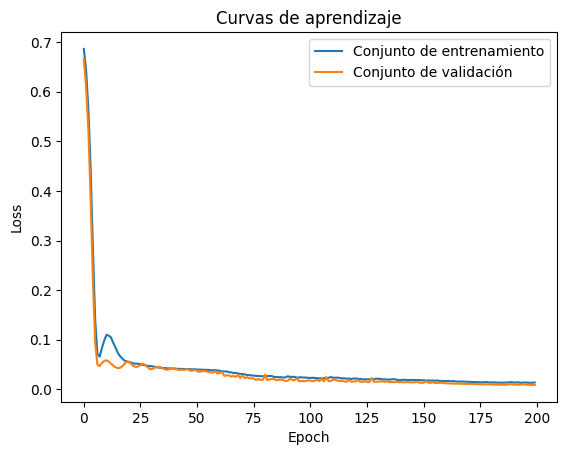

1/1 [==============================] - 0s 284ms/step


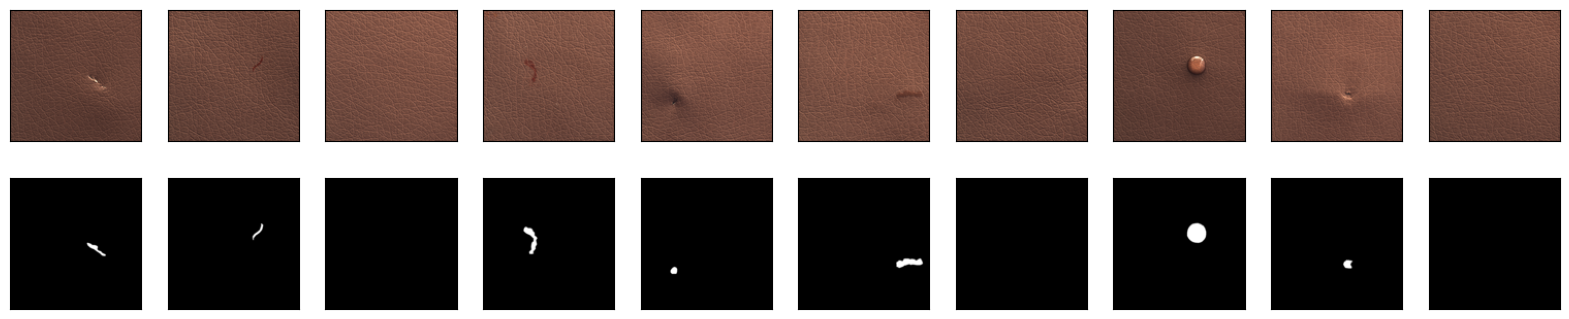

In [8]:
# -----------------------------
def plot_learning_curves(hist):
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Curvas de aprendizaje')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Conjunto de entrenamiento', 'Conjunto de validación'], loc='upper right')
  plt.show()


plot_learning_curves(history)

prediction = autoencoder.predict( x_test )


# Como la predicción son valores continuos entre 0 y 1 aplicamos un umbral...
prediction = (prediction > 0.2).astype('uint8')

# Al umbralizar y transformar a entero entremos una matriz de 0s y 1s.
# Multiplicamos por 255 para poder mostrar las imágenes de predicción.
prediction *= 255


# TODO - Llama a la función "show_images", que hemos definido antes, con los datos de test y la predicción
show_images(x_test, y_test)



# Evaluación

* Por último, dado que se trata de aprendizaje supervisado, vamos a evaluar el acierto de la red.

* Para esto usaremos la [métrica F1](https://en.wikipedia.org/wiki/F1_score), más adecuada cuando se trata de evaluar datos desbalanceados (en este caso hay mucho más fondo negro que píxeles blancos).

In [9]:
# Umbralizamos las etiquetas de test y las transformamos a valores enteros
test_flat = (y_test > 0.2).astype('uint8')

# Las pasamos a un vector 1D
test_flat = test_flat.flatten()

# Normalizamos las predicciones entre 0 y 1
pred_flat = (prediction / 255).flatten()

# Calculamos la métrica F1 usando la librería Sklearn
from sklearn.metrics import f1_score

print( 'Acierto F1: {:.4f}'.format( f1_score(test_flat, pred_flat, average='macro') ) )

Acierto F1: 0.7851
